In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install pydicom
!pip install SimpleITK

from PIL import Image
from glob import glob
import pandas as pd
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening, convex_hull_image
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
import numpy as np
import SimpleITK as sitk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 8.1 MB/s eta 0:00:00


In [3]:
def load_image(filename):
    # Reads the image using SimpleITK
    orimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    image_array = sitk.GetArrayFromImage(orimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(orimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(orimage.GetSpacing())))

    return image_array, origin, spacing

In [4]:
luna_subset_path = '/content/drive/MyDrive/Lung_Nodule_Analysis/subset0/'
file_list=glob(luna_subset_path+"*.mhd")

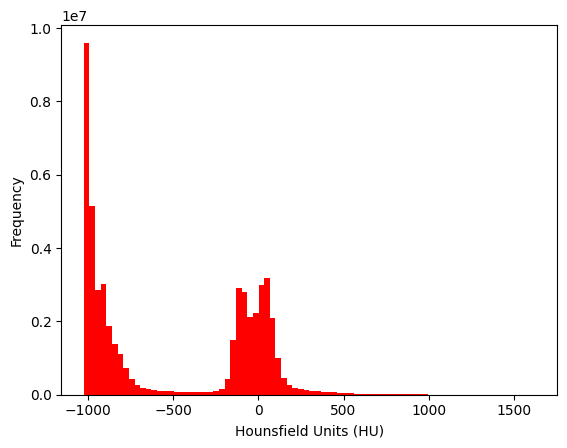

In [12]:
from matplotlib import pyplot as plt

img, origin, spacing = load_image(file_list[1])
first_patient_pixels = img
plt.hist(first_patient_pixels.flatten(), bins=80, color='r')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [13]:
img.shape

(195, 512, 512)

Refactoring the variable slice thickness in each image into a standardized format of 1mm axial , 1mm saggital and 1mm coronal according to the paper : https://www.slicer.org/wiki/Coordinate_systems#Image_coordinate_system

A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)!

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance.

Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while.
Source : https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial

In [14]:
def resample(image, previous_spacing, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array(previous_spacing, dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

In [15]:
img_refactored, spacing_refactored = resample(img, spacing)

<ipython-input-14-c94a7d1ab124>:10: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


In [16]:
print("Shape before refactoring : " , img.shape)
print("Shape after refactoring : " , img_refactored.shape)

Shape before refactoring :  (195, 512, 512)
Shape after refactoring :  (351, 370, 370)


Modify the value of threshold as per the density measured in HU of soft tissues

In [17]:
def plot_3d(image, threshold=-300):

    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)

    verts, faces, normals, values = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [1, 0.4, 0.4]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

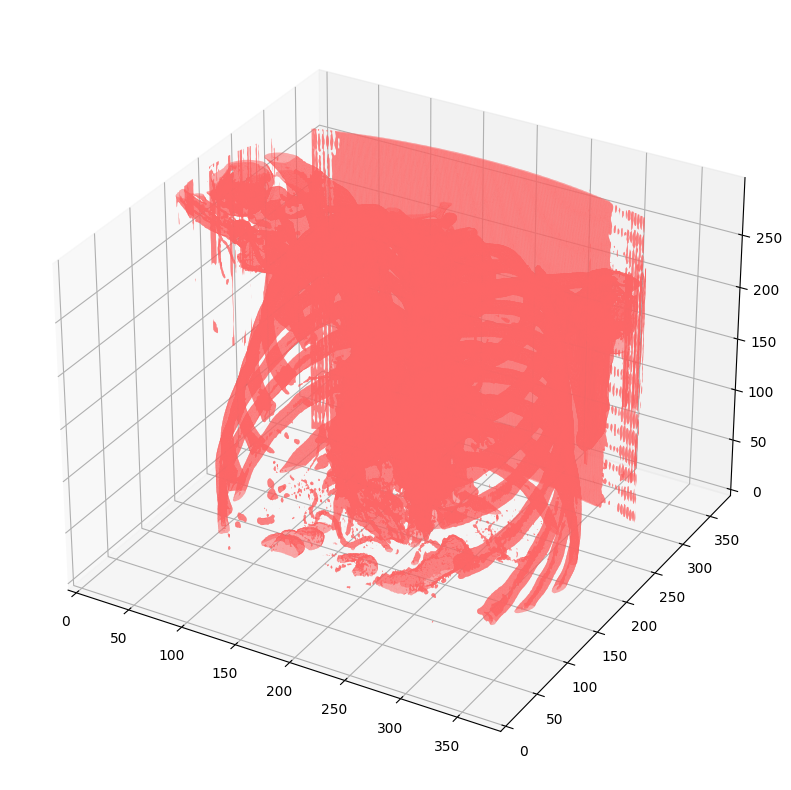

In [ ]:
plot_3d(img_refactored, 200)

In [18]:
def get_segmented_lungs(im, plot=False):
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    plt_number = 0

    if plot:
        f, plots = plt.subplots(12, 1, figsize=(5, 40))
        plots[plt_number].axis('off')
        plots[plt_number].set_title('Original Image')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    # Step 1: Convert into a binary image.

    binary = im < -604
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('Binary Transformation')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 2: Remove the blobs connected to the border of the image.

    cleared = clear_border(binary)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('Removal of small blobs around the Image')
        plots[plt_number].imshow(cleared, cmap=plt.cm.bone)
        plt_number += 1
    # Step 3: Label the image.

    label_image = label(cleared)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('Labeling Image Segments')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1

    # Step 4: Keep the labels with 2 largest areas and segment two lungs.

    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    labels = []
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
            else:
                coordinates = region.coords[0]
                labels.append(label_image[coordinates[0], coordinates[1]])
    else:
        labels = [1, 2]
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('Segmenting by Keeping the regions with Large Areas')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1
    # Step 5: Fill in the small holes inside the mask of lungs which we seperate right and left lung. r and l are symbolic and they can be actually left and right!

    r = label_image == labels[0]
    l = label_image == labels[1]
    r_edges = roberts(r)
    l_edges = roberts(l)
    r = ndi.binary_fill_holes(r_edges)
    l = ndi.binary_fill_holes(l_edges)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('Filling holes in Left Lung')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title('Filling holes in right lung')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1

    # Step 6: convex hull of each lung

    r = convex_hull_image(r)
    l = convex_hull_image(l)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('Convex Hull Left Lung')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title('Convex Hull Right Lung')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1
    # Step 7: joint two separated right and left lungs.

    sum_of_lr = r + l
    binary = sum_of_lr > 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('Joining Clean Left and Right Lung')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 8: Closure operation with a disk of radius 10. This operation is
    # to keep nodules attached to the lung wall.

    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('Closing Black Space with Radius 10 disk')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 9: Superimpose the binary mask on the input image.

    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title('Superimposing Binary Mask on Input Image')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    return im

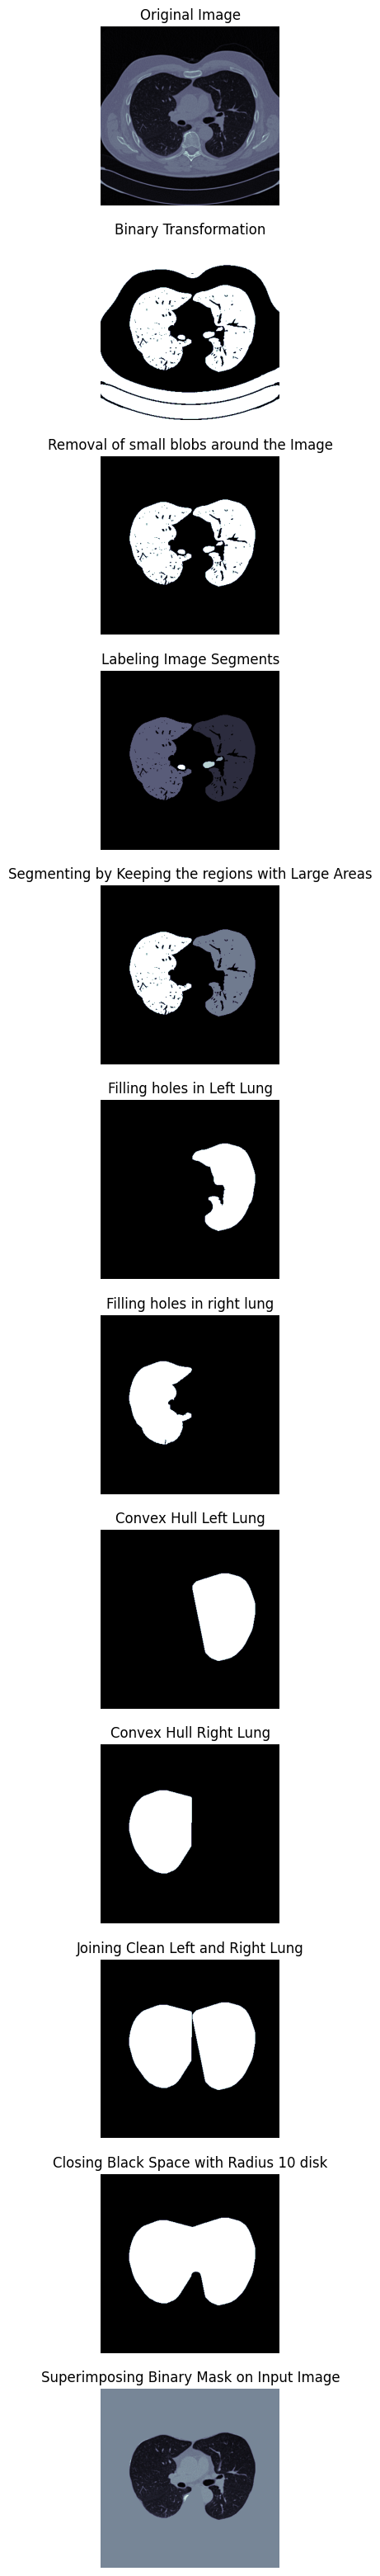

In [19]:
from matplotlib import pyplot as plt
tmp_2d_img = get_segmented_lungs(img_refactored[200,:,:], True)

In [20]:
img3 = np.asarray([get_segmented_lungs(im) for im in img_refactored])

<ipython-input-18-6edfea363a54>:81: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  l = convex_hull_image(l)
<ipython-input-18-6edfea363a54>:80: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  r = convex_hull_image(r)


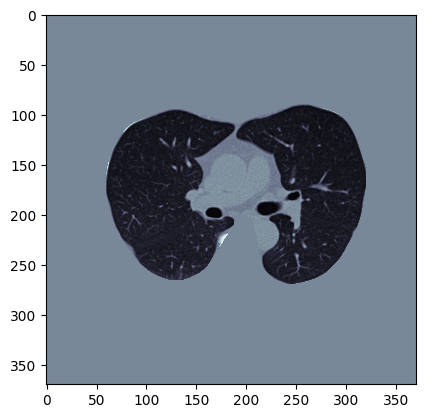

In [21]:
from matplotlib import pyplot as plt
plt.imshow(img3[201,:,:], cmap=plt.cm.bone)
plt.show()

Normalizing on the basis of Hounsfield Units






In [22]:
def normalize(image):
        MIN_BOUND = -1200
        MAX_BOUND = 600.
        image2 = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        image2[image2 > 1] = 1.
        image2[image2 < 0] = 0.
        image2 *= 255.
        return image2

In [23]:
img4 = normalize(img3)

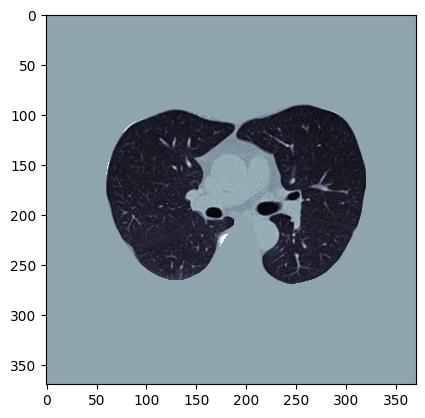

In [24]:
plt.imshow(img4[201,:,:], cmap=plt.cm.bone)
plt.show()